In [101]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import glob
from pathlib import Path
from datetime import datetime
import urllib3
# from numba import jit

import yfinance as yahooFinance
import investpy

import kit as kit

In [102]:
# pd.set_option('display.max_rows', 500)
# pd.reset_option('display.max_rows')

pd.options.mode.chained_assignment = None  # default='warn'
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

#### Function definition

In [147]:
class Asset:

    def __init__(self, ticker, name, source):
        self.ticker = ticker.upper()
        self.name = name
        self.source = source
        
    def get_asset_yahoo(self, ticker):
  
        ind = yahooFinance.Ticker(ticker).history(period="max")
        ind = ind["Close"]
        ind.name = ticker.split('.', 1)[0]

        return ind

    def get_asset_investing(self, ticker, name, date_beg='01/01/2009'):

        search = investpy.search_quotes(text=name, n_results=1)
        ind = search.retrieve_historical_data(from_date=date_beg, to_date=datetime.today().strftime('%d/%m/%Y'))["Close"]
        ind.name = ticker

        return ind

    def get_asset_local(self, ticker):

        ind = pd.read_csv(asset, sep=";", decimal=',').set_index('Date')
        ind.index = pd.to_datetime(ind.index, format="%d/%m/%Y")

        return ind

    def get_asset(self):
        
        if self.source.lower() == "yahoo":           
            prices = self.get_asset_yahoo(self.ticker)
        elif self.source.lower() == "investing":      
            prices = self.get_asset_investing(self.ticker, self.name)
        elif self.source.lower() == "csv":        
            prices = self.get_asset_local(self.ticker)
        else:
            raise ValueError(f"{self.source} is not a valid asset source")
        
        return pd.DataFrame(prices)

In [137]:
class Portfolio:
    
    def __init__(self, name, asset_list):
        self.name = name
        self.asset_list = asset_list

    ##### LOAD ####    
    def load(self):
        
        p = pd.concat([asset.get_asset() for asset in self.asset_list],axis=1)
        
        return p
    
    #### TRACK ####
    def frame_returns(self, p):
    
        r = p.pct_change()

        return r
    
    def create_trades(self):
    
        t = pd.DataFrame(columns=["Date", "Ticker", "Amount"])
        
        t = t.append({"Date": "07-01-2021","Ticker":"4GLD", "Amount":300.88}, ignore_index=True)
        t = t.append({"Date": "07-01-2021","Ticker":"XDEM", "Amount":3728.27}, ignore_index=True)
        t = t.append({"Date": "28-03-2021","Ticker":"4GLD", "Amount":-282.40}, ignore_index=True)
        t = t.append({"Date": "29-03-2021","Ticker":"4GLD", "Amount":273.24}, ignore_index=True)
        t = t.append({"Date": "14-07-2021","Ticker":"PRUD", "Amount":700.00}, ignore_index=True)
        t = t.append({"Date": "15-07-2021","Ticker":"FSMI", "Amount":2800.00}, ignore_index=True)
        t = t.append({"Date": "13-10-2021","Ticker":"WCOA", "Amount":2240.10}, ignore_index=True)
        t = t.append({"Date": "02-11-2021","Ticker":"ZPRS", "Amount":1494.57}, ignore_index=True)
        t = t.append({"Date": "02-11-2021","Ticker":"EUNZ", "Amount":1991.72}, ignore_index=True)
        t = t.append({"Date": "08-12-2021","Ticker":"BTC-EUR", "Amount":584.46}, ignore_index=True)
        t = t.append({"Date": "28-01-2022","Ticker":"4GLD", "Amount":518.20}, ignore_index=True)
        t = t.append({"Date": "28-01-2022","Ticker":"BRYN", "Amount":2487.15}, ignore_index=True)
        t = t.append({"Date": "11-02-2022","Ticker":"EUA", "Amount":624.00}, ignore_index=True)     

        return t

    def join_trades(self, r, t):
    
        t["Date"] = pd.to_datetime(t["Date"], format="%d-%m-%Y")
        t = t.set_index(["Ticker","Date"]).rename(columns={'Amount':'Trades'})
        r_stack = r.stack().reset_index().rename(columns={'level_1':'Ticker', 0: 'Returns'}).set_index(["Ticker", "Date"])
        rt = r_stack.join(t).unstack(level=0)
        rt.loc[:,"Trades"].fillna(0, inplace = True)

        return rt
    
    # @jit(nopython=True)
    def roll(self, a, b):
        res = np.empty(b.shape)
        res[0] = b[0]
        for i in range(1, res.shape[0]):
            res[i] = res[i-1] * (1 + a[i]) + b[i]
        return res

    def compute_wealth(self, rt):

        rtw = rt.copy()

        for i in rtw["Trades"].columns:
            rtw[("Total", i)] = roll(*np.nan_to_num(rtw[[("Returns", i), ("Trades", i)]].values.T))

        return rtw
    
    def portfolio_rets_weights(self, rtw):
    
        w = rtw["Total"].div(rtw["Total"].sum(axis=1), axis=0)   
        r = rtw["Returns"]   
        r['PORT'] =  (weights * r).sum(axis=1) 

        return r, w
    
    def rolling_vol(self, r, time_period = 90, col_drop_plot = None):
    
        roll_vol = r.drop(columns = col_drop_plot).rolling(time_period, min_periods = int(time_period*0.2)).apply(kit.annualize_vol)   
        roll_vol.plot(figsize=(16,5), title = '{}-periods rolling volatility'.format(time_period))
    
        return roll_vol

    def portfolio_report(self, df, weights = None, date_beg = None, date_end = None, col_drop_plot = None, time_period = 90):

        if date_end == None:
            date_end = df.index[-1]

        if col_drop_plot == None:
            (1+df.dropna())[date_beg:date_end].cumprod().plot(figsize=(16,5), title = 'Cumulative returns') #Plot wealth
            df.dropna()[date_beg:date_end].apply(lambda r: kit.drawdown(r).Drawdown).plot(figsize=(16,5), title = 'Drawdown') #Plot drawdown
        else:
            (1+df.drop(columns = col_drop_plot).dropna())[date_beg:date_end].cumprod().plot(figsize=(16,5), title = 'Cumulative returns') #Plot wealth
            df.drop(columns = col_drop_plot).dropna()[date_beg:date_end].apply(lambda r: kit.drawdown(r).Drawdown).plot(figsize=(16,5), title = 'Drawdown') #Plot drawdown

        stats = kit.summary_stats(df.dropna()[date_beg:date_end], riskfree_rate=0)
    #     roll_vol = rolling_vol(df.dropna()[date_beg:date_end], time_period = time_period, col_drop_plot = col_drop_plot)
    
        if weights is not None:
            weights.dropna().plot(figsize=(16,5), title = 'Portfolio weights')

        return stats
    
    def track(self):
        
        p = self.load()
        r = self.frame_returns(p)
        t = self.create_trades()
        rt = self.join_trades(r, t)
        rtw = self.compute_wealth(rt)
        r, w = self.portfolio_rets_weights(rtw)
        stats = self.portfolio_report(r, weights = w, date_beg = "2021-01-06", col_drop_plot = ["BTC-EUR", "EUA"])
        roll_vol = rolling_vol(r.dropna()["2021-01-06":], time_period = 90, col_drop_plot = ["BTC-EUR", "EUA"])
        
        return stats
    

#### Parameters initialization

In [109]:
# Local: Write your own path. csv must contain only two columns, 'Date' with date format "%d/%m/%Y" and 'asset name' (e.g FSMI) with asset prices
list_local = glob.glob(r'C:\Users\aguil\OneDrive\Escritorio\Escritorio\Python Projects\6. Investing projects\data\Assets' + "/*.csv")

In [ ]:
asset1 = Asset(ticker="EUNL.DE", name="MSCI World", source="Yahoo")
asset2 = Asset(ticker="XDEM.F", name="MSCI World Momentum", source="Yahoo")
asset3 = Asset(ticker="4GLD.DE", name="Xetra-Gold", source="Yahoo")
asset4 = Asset(ticker="WCOA.MI", name="Wisdomtree Enhac Comm", source="Yahoo")
asset5 = Asset(ticker="ZPRS.DE", name="MSCI World Small Cap", source="Yahoo")
asset6 = Asset(ticker="EUNZ.F", name="MSCI EM Min Vol", source="Yahoo")
asset7 = Asset(ticker="BTC-EUR", name="Bitcoin", source="Yahoo")
asset8 = Asset(ticker="BRYN.DE", name="Berkshire Hathaway", source="Yahoo")
asset9 = Asset(ticker="FSMI", name="Fundsmith Equity T Acc EUR", source="Investing")
asset10 = Asset(ticker="PRUD", name="MFS Meridian Prudent Wealth I1 EUR", source="Investing")
asset11 = Asset(ticker="EUA", name="Carbon Emissions", source="Investing")
asset_list = [asset1, asset2, asset3, asset4, asset5, asset6, asset7, asset8, asset9, asset10, asset11]

#### Execution

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Ticker,,,,,,,,
4GLD,0.013926,0.123814,-0.477769,4.461959,0.013555,0.019693,0.112478,-0.091344
BRYN,0.440450,0.171410,-0.007560,4.041634,0.015996,0.021712,2.569576,-0.075175
BTC-EUR,0.351021,0.778156,0.132893,4.817727,0.062126,0.088386,0.451094,-0.523755
EUA,1.463226,0.418676,-0.689171,6.060651,0.042069,0.059853,3.494892,-0.178013
EUNL,0.220667,0.140623,-0.594867,5.800852,0.014556,0.020811,1.569201,-0.098529
EUNZ,0.110112,0.116438,-0.386458,4.274804,0.012200,0.016431,0.945672,-0.054096
FSMI,0.130399,0.121407,-0.276000,4.278878,0.012478,0.016769,1.074062,-0.126310
PRUD,0.077627,0.065273,-0.538894,4.739130,0.006997,0.010127,1.189272,-0.048746
WCOA,0.415282,0.136663,-1.270823,8.272911,0.014588,0.021007,3.038737,-0.080140


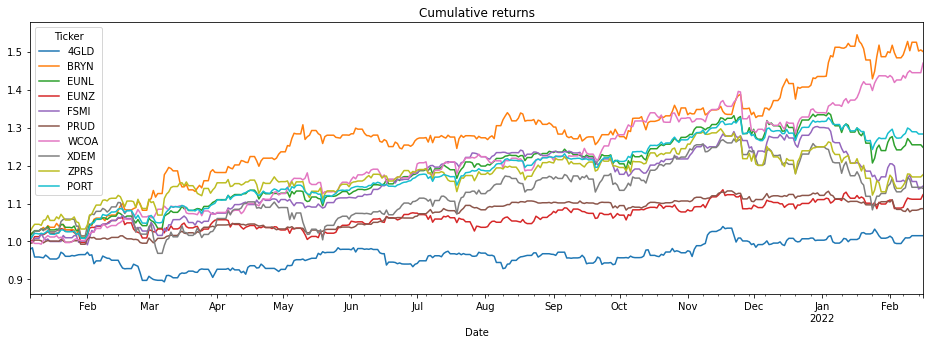

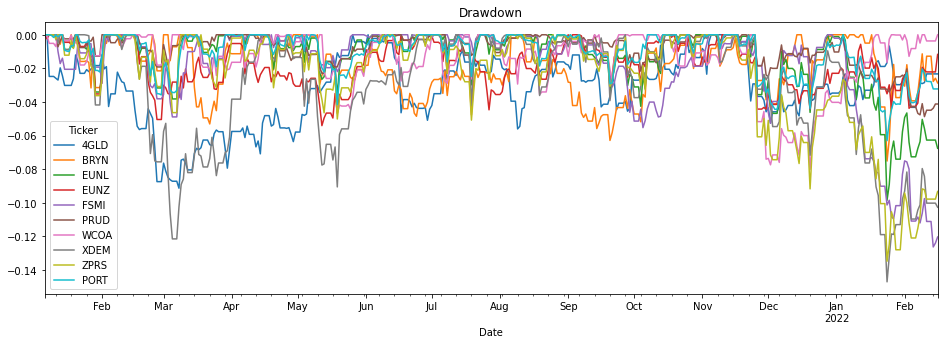

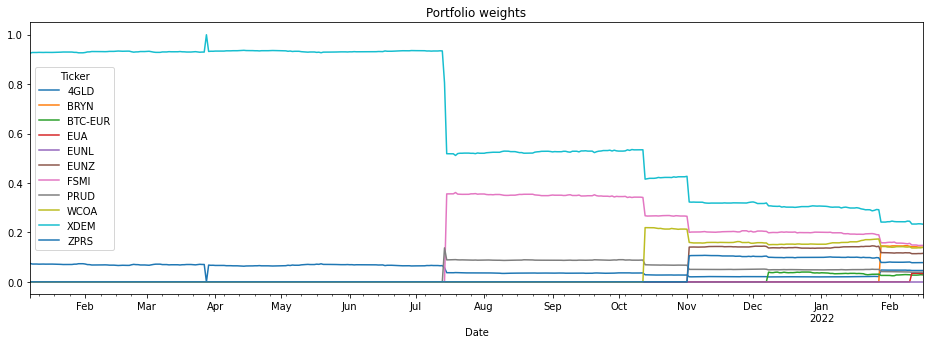

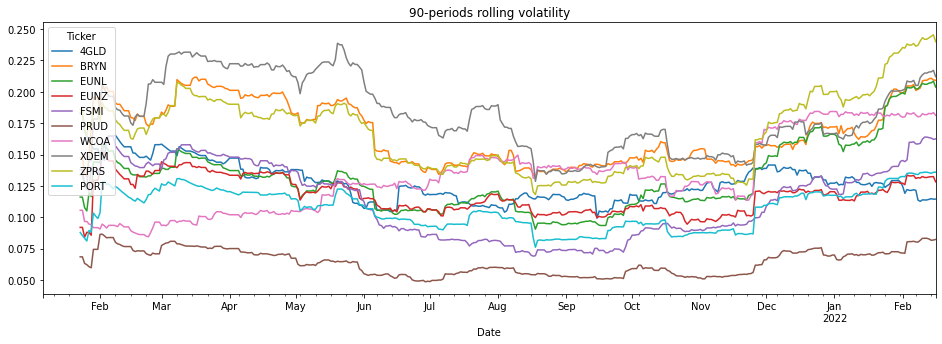

In [152]:
portfolio = Portfolio(name="Jaime's Portfolio", asset_list=asset_list)
stats = portfolio.track()
stats

# Other analysis

#### Test current weights on a longer period

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Ticker,,,,,,,,
4GLD,0.101626,0.127321,-0.069093,9.406602,0.012054,0.018943,0.798192,-0.182267
BRYN,0.141826,0.213298,-0.136150,8.907240,0.020416,0.032357,0.664917,-0.287161
BTC-EUR,0.420171,0.782093,-0.092488,10.514978,0.060330,0.092956,0.537240,-0.827479
EUA,0.794918,0.451065,-0.410070,6.343682,0.044987,0.062901,1.762312,-0.489272
EUNL,0.126321,0.175850,-0.983832,14.541002,0.018001,0.028440,0.718342,-0.336322
EUNZ,0.053138,0.152571,-0.966907,9.701126,0.016862,0.024036,0.348284,-0.267947
FSMI,0.131773,0.153322,-0.773141,8.594535,0.016497,0.024412,0.859452,-0.269354
PRUD,0.088401,0.073400,-0.106927,4.904794,0.007370,0.010411,1.204371,-0.073030
WCOA,0.096482,0.116079,-0.628618,8.294631,0.012623,0.017827,0.831180,-0.218176


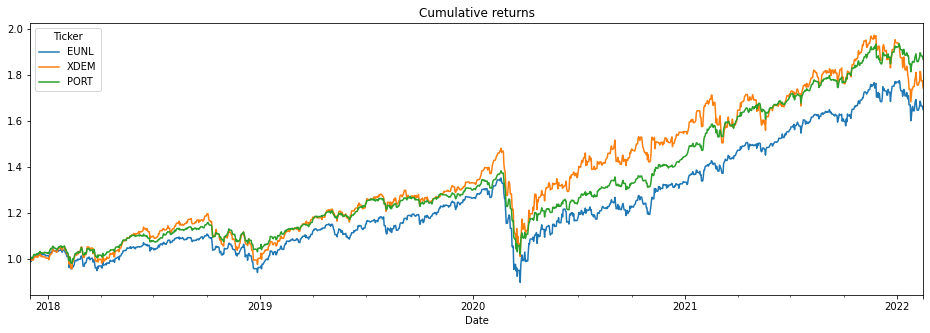

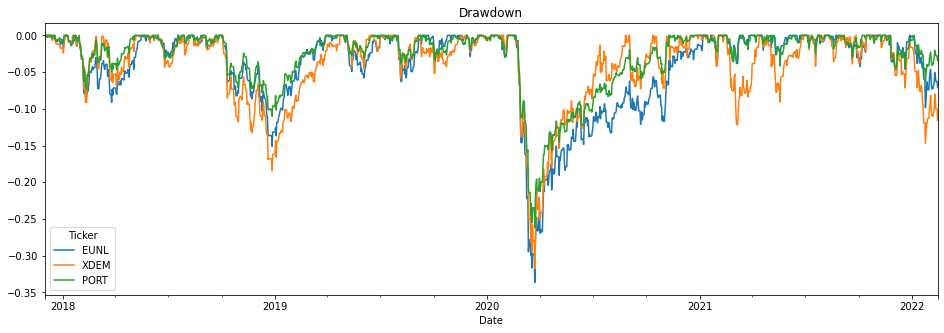

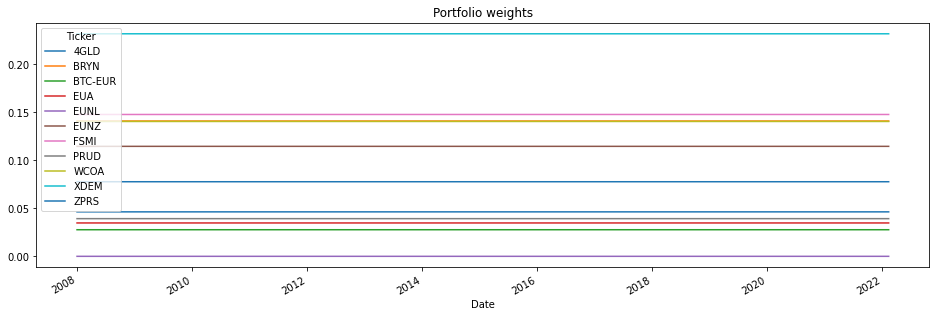

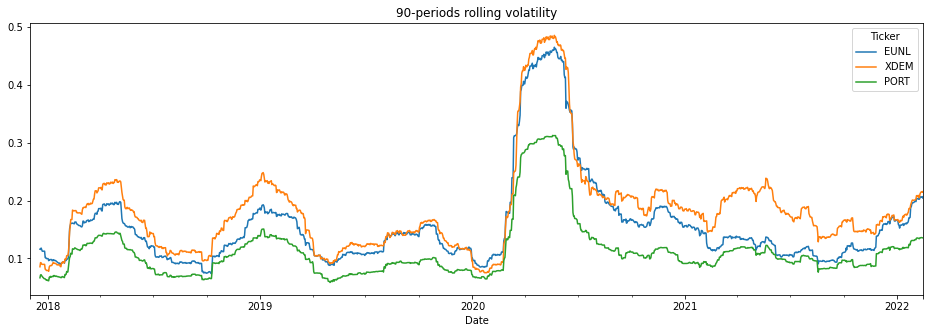

In [112]:
weights = weights_portfolio.copy()
weights.iloc[:-1,:]=np.nan
weights=weights.fillna(method="bfill")

df_portfolio = rets_trades_wealth["Returns"]  
df_portfolio['PORT'] = (weights * df_portfolio).sum(axis=1) 

col_drop_plot = ["PRUD", "BTC-EUR", "ZPRS", "WCOA", "EUNZ", "4GLD", "FSMI", "BRYN", "EUA"]

stats_long = portfolio_report(df_portfolio, date_beg = "2017-12", weights = weights, col_drop_plot = col_drop_plot)
roll_vol = rolling_vol(df_portfolio.dropna()["2017-12":], col_drop_plot = col_drop_plot)
stats_long

In [115]:
weights.iloc[-1]

Ticker
4GLD       0.046258
BRYN       0.140783
BTC-EUR    0.027666
EUA        0.034715
EUNL       0.000000
EUNZ       0.114413
FSMI       0.147570
PRUD       0.039190
WCOA       0.140293
XDEM       0.231514
ZPRS       0.077598
Name: 2022-02-14 00:00:00, dtype: float64

#### Monthly/weekly/business days report

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Ticker,,,,,,,,
4GLD,0.100185,0.115278,-0.840965,5.857783,0.026851,0.040254,0.869070,-0.173035
BRYN,0.152472,0.206318,-0.612340,5.870307,0.047149,0.072263,0.739017,-0.254979
BTC-EUR,0.451147,0.792962,-0.088236,3.769650,0.167597,0.228991,0.568939,-0.823520
EUA,0.779454,0.446235,-0.083653,4.046706,0.088366,0.105153,1.746733,-0.453457
EUNL,0.128491,0.169854,-1.664956,13.484688,0.040819,0.057499,0.756477,-0.292886
EUNZ,0.048182,0.139679,-1.104581,7.761651,0.034330,0.048332,0.344946,-0.243539
FSMI,0.131932,0.150484,-1.711637,10.714517,0.037245,0.053853,0.876715,-0.221121
PRUD,0.088236,0.066881,-0.843337,5.739501,0.015080,0.020931,1.319301,-0.056389
WCOA,0.093765,0.107125,-0.643918,5.231757,0.024385,0.031443,0.875287,-0.189856


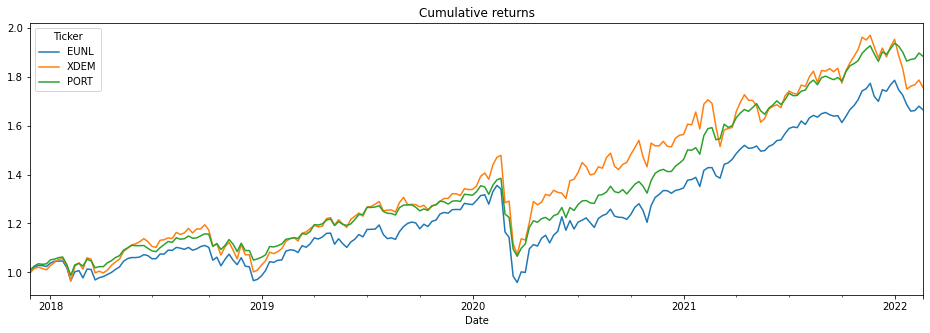

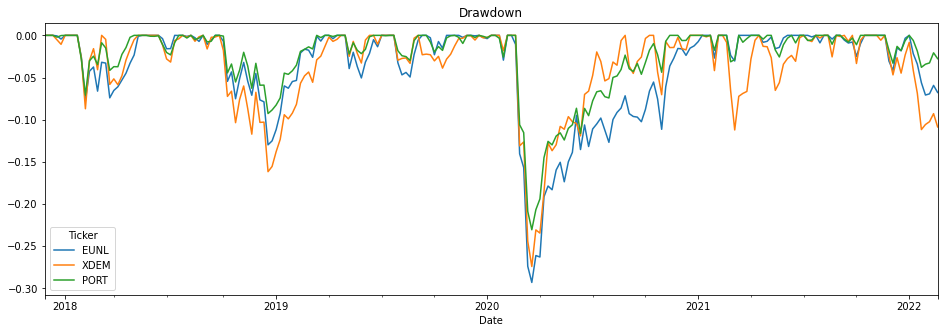

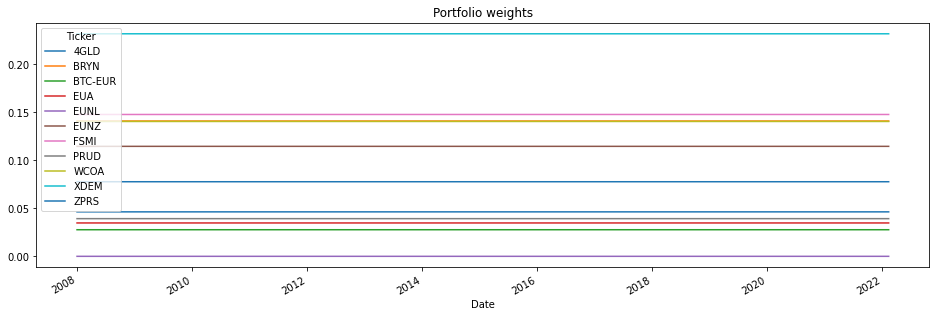

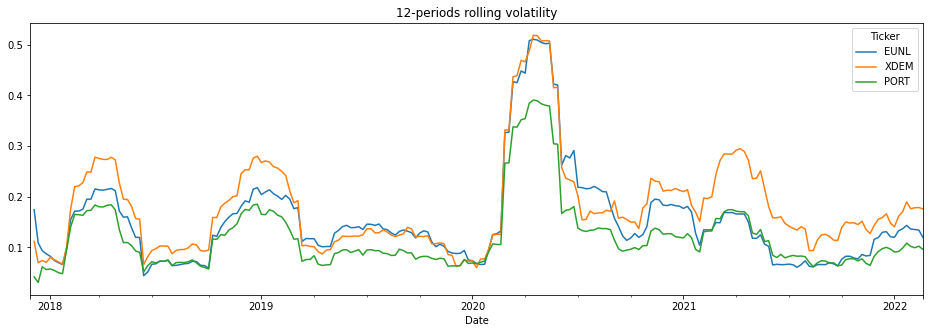

In [113]:
df_portfolio_w = df_portfolio.resample('W').apply(kit.compound)
df_portfolio_m = df_portfolio.resample('M').apply(kit.compound)
# df_portfolio_b = df_portfolio.resample('B').apply(kit.compound)

stats_w = portfolio_report(df_portfolio_w, date_beg = "2017-12", weights = weights, col_drop_plot = col_drop_plot)
roll_vol = rolling_vol(df_portfolio_w.dropna()["2017-12":], time_period = 12, col_drop_plot = col_drop_plot)
stats_w

#### Plot density function of returns

(-0.04, 0.04)

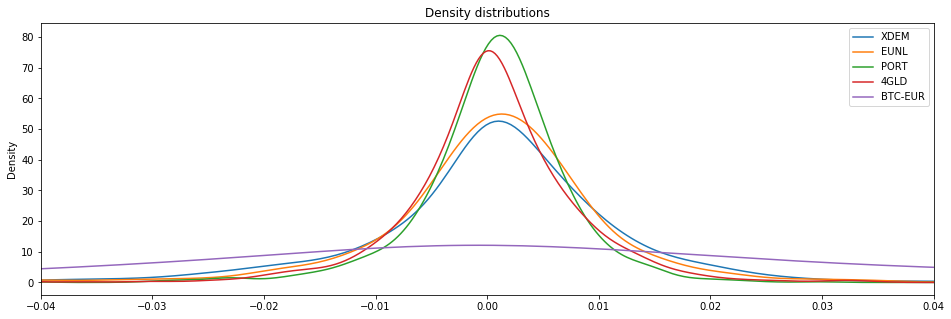

In [60]:
r = df_portfolio_b.loc["2017-12":, ["XDEM", "EUNL", "PORT", "4GLD", "BTC-EUR"]]
x_lim = 0.04

# r.hist(bins=30, figsize=(15,10), label='x')

r.plot.kde(figsize=(16,5), title = 'Density distributions')
plt.xlim([-x_lim, +x_lim])

#### Get rolling correlation of rest of assets against a particular asset

,4GLD,BTC-EUR,WCOA,PRUD,EUNZ,FSMI,XDEM,PORT,ZPRS,EUNL
0,-0.018522,0.175583,0.450048,0.684403,0.686326,0.715056,0.76495,0.882312,0.903893,1.0


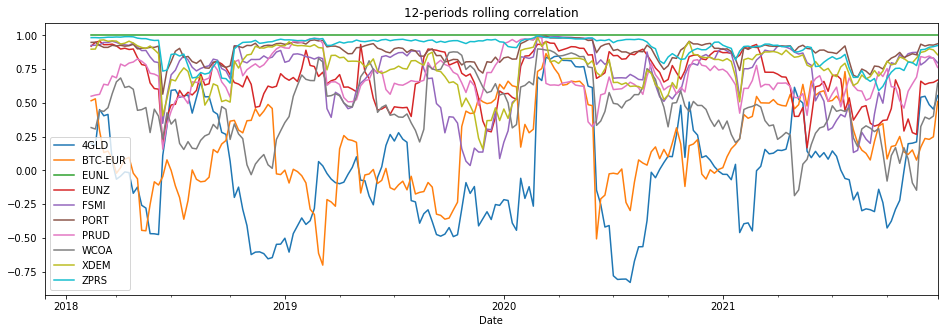

In [61]:
def rolling_corr(r, time_period = 90, col= 'XDEM'):
    
    corr = r.rolling(time_period).corr()[col].unstack(level = 1)
    
    corr.plot(figsize=(16,5), title = '{}-periods rolling correlation'.format(time_period))
    
    return pd.DataFrame(corr.mean().sort_values(ascending = True)).T

r = df_portfolio_w.loc["2017-12":]

# Note: Daily data and data quality issues in funds could give unaccurate results (better with long monthly periods)
rolling_corr(r, time_period = 12, col = 'EUNL')

#### Study inclusion of alternative asset in the portfolio

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0.0,0.138123,0.123747,-1.150235,16.802194,0.010421,0.017306,1.116177,-0.257945
0.1,0.133817,0.127079,-1.132132,17.448385,0.010605,0.017820,1.053023,-0.266450
0.2,0.129434,0.130965,-1.100583,17.946555,0.010829,0.018390,0.988306,-0.274881
0.3,0.124973,0.135357,-1.058777,18.293469,0.011091,0.019011,0.923285,-0.283239
0.4,0.120436,0.140206,-1.009828,18.498091,0.011392,0.019682,0.858991,-0.291523
0.5,0.115824,0.145468,-0.956503,18.577211,0.011729,0.020419,0.796216,-0.299735
0.6,0.111138,0.151099,-0.901094,18.551416,0.012100,0.021163,0.735532,-0.307874
0.7,0.106380,0.157060,-0.845384,18.441996,0.012502,0.021936,0.677321,-0.315941
0.8,0.101550,0.163314,-0.790685,18.268921,0.012933,0.022733,0.621807,-0.323936
0.9,0.096649,0.169829,-0.737906,18.049738,0.013390,0.023568,0.569096,-0.331860


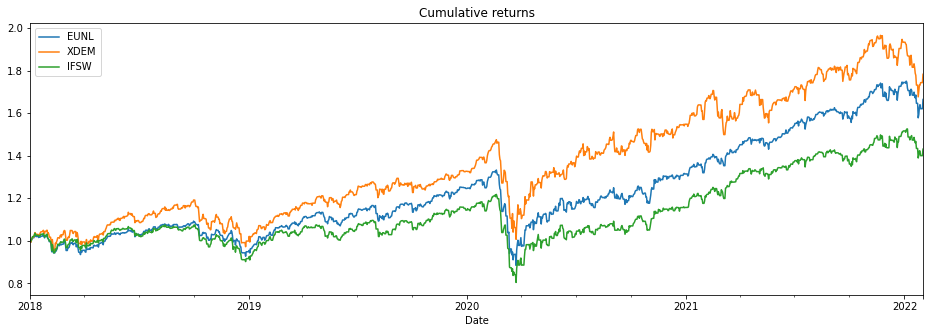

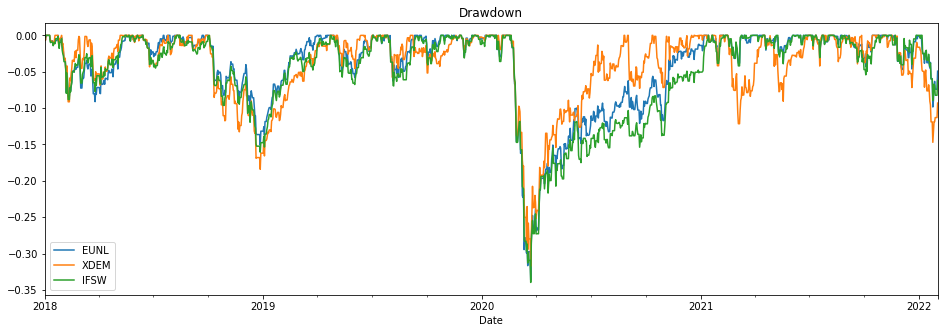

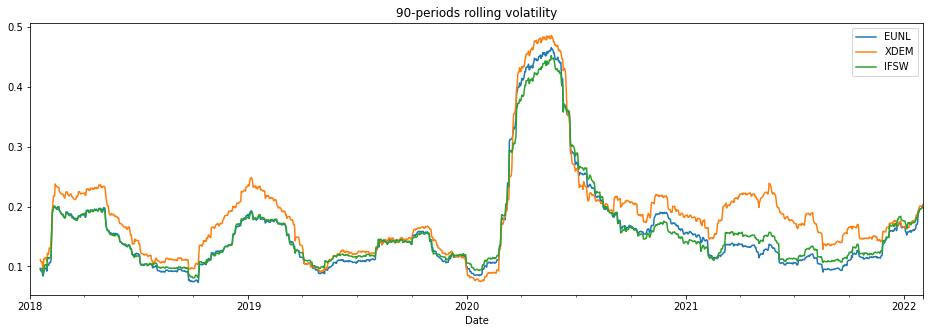

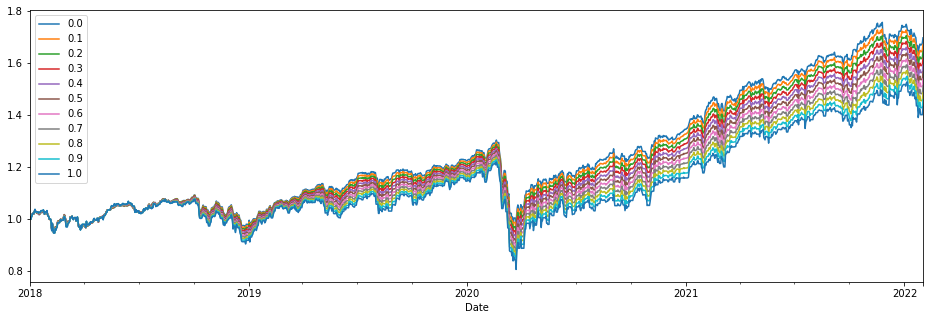

In [20]:
alt_name = 'IFSW'

# Get asset returns
alt_ticker = ['IFSW.MI']
alt_price = get_asset(list_yahoo = alt_ticker) 
alt_rets = alt_price.pct_change()["2016-09-28":]

# Append returns
r = pd.concat([rets_trades_wealth["Returns"], alt_rets], axis = 1)
r.loc[:,alt_name] = r.loc[:,alt_name].fillna(0)
r = r.dropna()

# Optional: Include in portfolio report
col_drop_plot = ["PRUD", "BTC-EUR", "ZPRS", "WCOA", "EUNZ", "4GLD", "FSMI", "BRYN"]
portfolio_report(r, date_beg = "2018", col_drop_plot = col_drop_plot)
roll_vol = rolling_vol(r["2018":], col_drop_plot = col_drop_plot)

# Optional: Get correlation matrix
# r['2018':].resample('M').apply(kit.compound).corr()

# Define a function that include given weight into portolio weights
def normalize(weight_series,  w):

    a = weight_series
    a = a*(1-w)
    a[alt_name] = w
    
    return a

# Define weights to backtest
weight_series = weights_portfolio.iloc[-1]
weights = np.array([normalize(weight_series,  w) for w in np.linspace(0,1,11)])

# Get results
results = (r @ weights.T)
results.columns = np.around(weights[:,-1],2).tolist()
(1+results["2018":]).cumprod().plot(figsize=(16,5))
kit.summary_stats(results["2018":], riskfree_rate = 0)

In [9]:
alt_name = 'IFSW'

# Get asset returns
alt_ticker = ['IFSW.MI']
alt_price = get_asset(list_yahoo = alt_ticker) 
alt_rets = alt_price.pct_change()["2016-09-28":]

#### EUA Analysis

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0.00,0.137413,0.161662,-0.689570,12.043858,0.016293,0.025235,0.850003,-0.336322
0.01,0.140878,0.161008,-0.693679,12.384250,0.015942,0.024874,0.874972,-0.336700
0.02,0.144313,0.160565,-0.689952,12.346519,0.015883,0.024786,0.898781,-0.337079
0.03,0.147718,0.160339,-0.682891,12.260382,0.015848,0.024724,0.921285,-0.337462
0.04,0.151092,0.160331,-0.672210,12.130856,0.015834,0.024679,0.942377,-0.337847
0.05,0.154437,0.160542,-0.657699,11.965145,0.015840,0.024653,0.961969,-0.338235
0.06,0.157750,0.160971,-0.639232,11.772278,0.015864,0.024659,0.979992,-0.338625
0.07,0.161033,0.161616,-0.616773,11.562628,0.015902,0.024682,0.996393,-0.339018
0.08,0.164284,0.162474,-0.590374,11.347360,0.015952,0.024758,1.011141,-0.339414
0.09,0.167504,0.163543,-0.560175,11.137835,0.016012,0.024866,1.024223,-0.339812


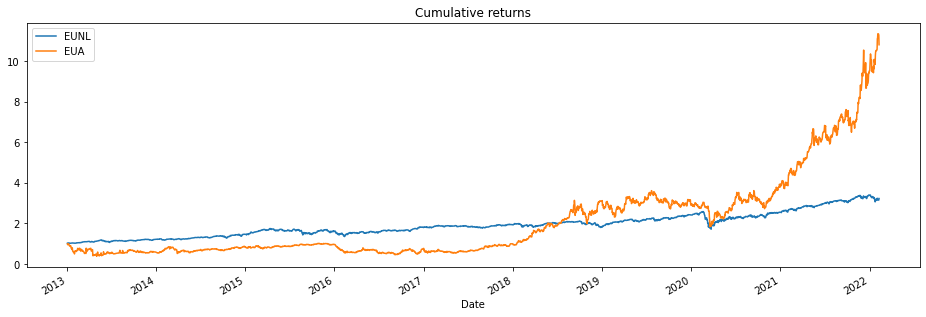

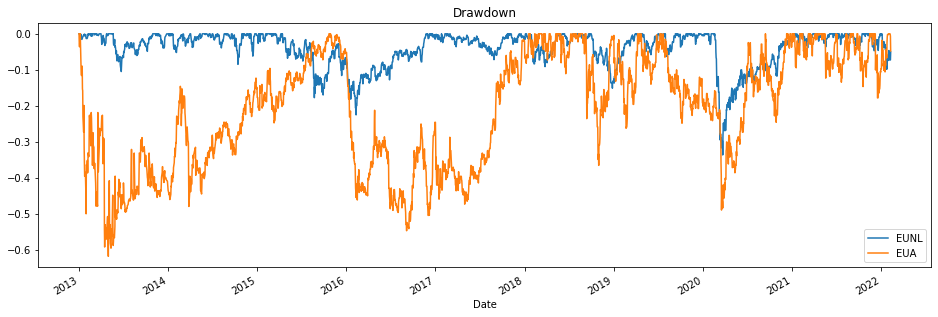

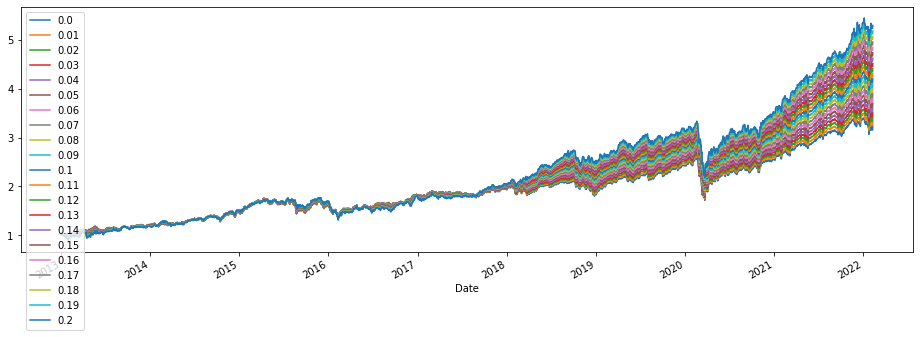

In [75]:
alt_ticker = [['Carbon Emissions', 'EUA']]
alt_price = get_asset(list_investing = alt_ticker)

alt_rets = alt_price.pct_change()["2013-01-01":]
# ["2016-09-28":]
alt_name = 'EUA'

# Append returns
r = pd.concat([rets_trades_wealth["Returns"], alt_rets], axis = 1)
r[alt_name] = r[alt_name].fillna(0)
r = r[["EUNL", "EUA"]]
# r = r.dropna()

# Optional: Include in portfolio report
# col_drop_plot = ["PRUD", "BTC-EUR", "ZPRS", "WCOA", "EUNZ", "4GLD", "FSMI", "BRYN"]
stats = portfolio_report(r, date_beg = "2013", col_drop_plot = None)
# roll_vol = rolling_vol(r["2013":], time_period = 90, col_drop_plot = None)

# Optional: Get correlation matrix
# r['2013':].resample('M').apply(kit.compound).corr()

# Define a function that include given weight into portolio weights
def normalize(weight_series,  w):

    a = weight_series
    a = a*(1-w)
    a[alt_name] = w
    
    return a

# Define weights to backtest
# weight_series = weights_portfolio.iloc[-1]
weight_series = weights_portfolio[["EUNL"]].iloc[-1]
weight_series["EUNL"] = 1
# weight_series = 1
weights = np.array([normalize(weight_series,  w) for w in np.linspace(0,0.2,21)])

# Get results
results = (r @ weights.T)
results.columns = np.around(weights[:,-1],2).tolist()
(1+results["2013":]).cumprod().plot(figsize=(16,5))
kit.summary_stats(results["2013":], riskfree_rate = 0)

,EUA,EUNL
0,0.161823,1.0


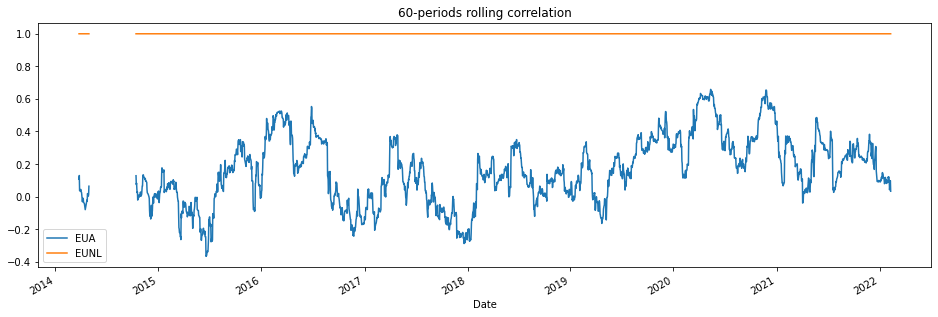

In [77]:
def rolling_corr(r, time_period = 90, col= 'XDEM'):
    
    corr = r.rolling(time_period).corr()[col].unstack(level = 1)
    
    corr.plot(figsize=(16,5), title = '{}-periods rolling correlation'.format(time_period))
    
    return pd.DataFrame(corr.mean().sort_values(ascending = True)).T

# r = pd.concat([rets_trades_wealth["Returns"], alt_rets], axis = 1)
# r[alt_name] = r[alt_name].fillna(0)
# r = r[["WCOA", "EUA"]]["2018":]

r_w = r.resample('W').apply(kit.compound)
r_m = r.resample('M').apply(kit.compound)

# Note: Daily data and data quality issues in funds could give unaccurate results (better with long monthly periods)
rolling_corr(r["2013":], time_period = 60, col = 'EUNL')
# rolling_corr(r_w["2014":], time_period = 12, col = 'WCOA')
# rolling_corr(r_m["2014":], time_period = 6, col = 'EUNL')

<AxesSubplot:xlabel='Date'>

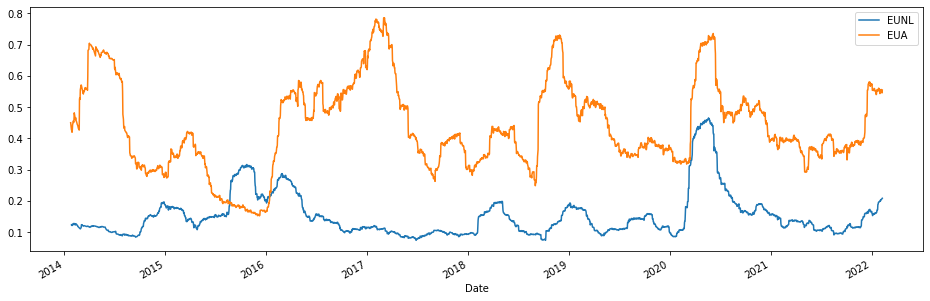

In [86]:
time_period = 90
roll_vol = r["2014":].rolling(time_period, min_periods = int(time_period*0.2)).apply(kit.annualize_vol)
roll_vol.plot(figsize=(16,5))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EUNL,0.146748,0.211348,-1.019292,13.257080,0.022018,0.034710,0.694343,-0.336322
EUA,0.860172,0.465638,-0.397023,6.453978,0.045980,0.065531,1.847297,-0.393436


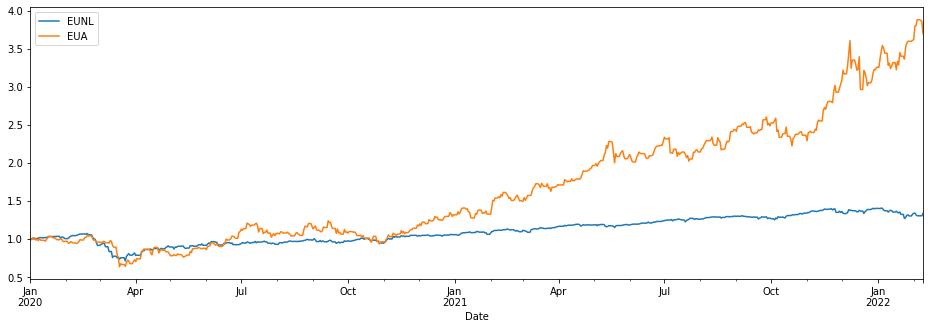

In [100]:
r_t = r["2020":]
(1+r_t).cumprod().plot(figsize=(16,5))
kit.summary_stats(r_t, riskfree_rate = 0)